# Прогнозирование продаж Интернет-магазина

**Цель Заказчика.** Прогноз продаж на следующий месяц для организации точного объема закупа товара.

**Цель исследования.** Построить модель для прогнозирования объема продаж на следующий месяц по метрике `buying_score` с приемлемой точностью. Учесть, что недозакуп приоритетен перед перезакупом

**Задачи:**

- Загрузить данные и выполнить их ресемплирование по одному месяцу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы

**Входные данные от Заказчика.** Файл в формате .csv с данными о количестве продаж

**Ожидаемый результат.** Построена модель для предсказания объема продаж на следующий месяц, с приемлемой точностью по метрики `buying_score`.


**Метрики**

Оценка качества прогнозирования по метрике  `$$buying\,score = (1 + \hat{y})/(1 + y)$$`. 

Перезакуп `($$buying\,score > 1$$)` более вреден, чем недозакуп `($$buying\,score < 1$$)`.  

**Входящие условия**

Предоставлено два датасета, один из которых имеет временной ряд только 15 значений. Такая выборка не позволяет строить достоверный прогноз.

Для построения прогнозной модели выбран второй датасет, с количеством данных 174 за два года.

Подобную разрежённость значений можно применить только для прогнозирования продаж на один календарный месяц.

In [34]:
# Импотрт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy.random import RandomState

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Исследование и подготовка данных

In [35]:
# Прочитаем датасет
df = pd.read_csv('C:\\Users\\User\\Downloads\\clean_sales_fabric_96_sku_265_warehouse_1.csv', index_col=[0], parse_dates=[0])
df.head()

,count
date,
2017-10-30,3
2017-10-30,1
2017-10-27,1
2017-10-22,1
2017-10-13,1


In [36]:
df.shape

(174, 1)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174 entries, 2017-10-30 to 2018-08-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   174 non-null    int64
dtypes: int64(1)
memory usage: 2.7 KB


In [38]:
# Проверим на аномалии
df['count'].value_counts()

1    128
2     37
3      8
4      1
Name: count, dtype: int64

In [39]:
# Проверим временной ряд на монотонность
df.index.is_monotonic

C:\Users\User\AppData\Local\Temp\ipykernel_11852\2490844368.py:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic


False

In [40]:
# Выполним ресемплированиеданных по одному месяцу

df = df.resample('1M').sum()
df.head()

,count
date,
2015-07-31,1
2015-08-31,1
2015-09-30,3
2015-10-31,2
2015-11-30,7


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2015-07-31 to 2018-08-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   38 non-null     int64
dtypes: int64(1)
memory usage: 608.0 bytes


In [42]:
# Проверим новый временной ряд на монотонность
df.index.is_monotonic

C:\Users\User\AppData\Local\Temp\ipykernel_11852\1733717891.py:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic


True

Ряд монотонный. Можно применять его для прогнозирования

**Графики временного ряда и временного ряда со скользящей средней**

<Figure size 500x700 with 0 Axes>

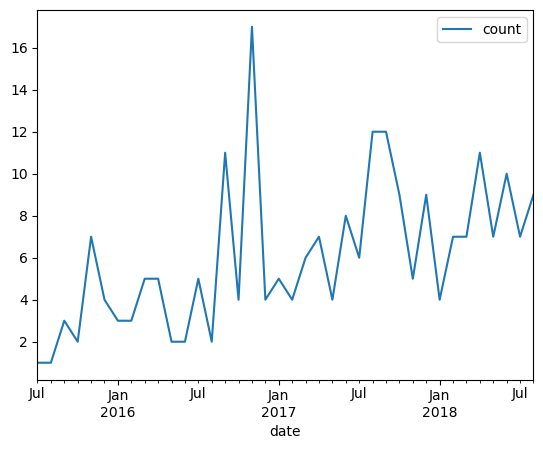

In [43]:
plt.figure(figsize=(5, 7))
df.plot()
plt.show()

<Axes: xlabel='date'>

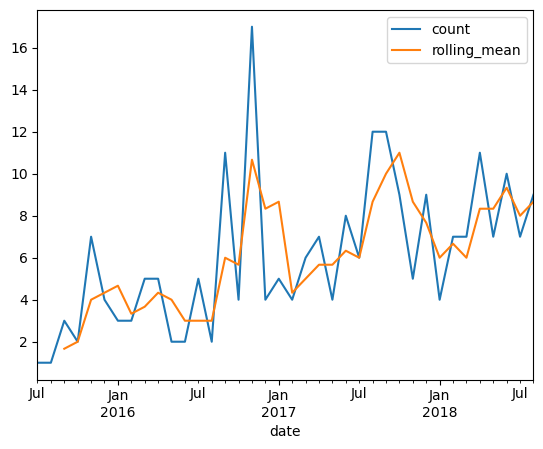

In [44]:
df['rolling_mean'] = df.rolling(3).mean()
df.plot()

## Построение прогноза

In [45]:
# функция метрики buying_score
def buying_score(fact, predict):
    fact_list = fact.tolist()
    a = 0
    for i in range(len(fact_list)):
        a += (1+predict[i]) / (1+fact_list[i])
        
    return a / len(fact_list)

In [46]:
# введем константу
state = RandomState(12345)

In [47]:
# Выделим тестовую выборку
train, test = train_test_split(df, test_size=.1, shuffle=False, random_state=state)

In [48]:
# Оценим качество прогноза константной моделью
pred_median = [train['count'].median() for i in range(len(test['count']))]
bs_pred_median = buying_score(test['count'], pred_median)
print(f'Качество константной модели по buying_score {bs_pred_median:.4f}')

Качество константной модели по buying_score 0.6614


In [49]:
# Оценим качество прогноза моделью по предыдущим значениям
pred_previous = test['count'].shift(fill_value=int(train.iloc[-1, 0]))
bs_pred_previous = buying_score(test['count'], pred_previous)
print(f'Качество модели по предыдущим значениям по buying_score {bs_pred_previous:.4f}')

Качество модели по предыдущим значениям по buying_score 1.1006


In [50]:
df.head()

,count,rolling_mean
date,,
2015-07-31,1,NaN
2015-08-31,1,NaN
2015-09-30,3,1.666667
2015-10-31,2,2.000000
2015-11-30,7,4.000000


In [51]:
# Уберем столбец со сколбзящей средней
df.drop(['rolling_mean'], axis=1, inplace=True)

In [52]:
# Напшем функцию создания признаков
def make_features(df, max_lag, rolling_mean_size):
    df_new = df.copy()
    df_new['year'] = df_new.index.year
    df_new['month'] = df_new.index.month
    
    for i in range (1, max_lag+1):
        a = 'lag_' + str(i)
        df_new[a] = df_new['count'].shift(i)
    
    df_new['rolling_mean'] = df_new['count'].shift().rolling(rolling_mean_size).mean()
    
    # кодирование
    df_new = pd.get_dummies(df_new, columns=['year'], drop_first=True)
    df_new = pd.get_dummies(df_new, columns=['month'], drop_first=True)
    
    return df_new

In [53]:
# Определим лучшие параметры методом кросс-валидации

best_bs_reg = 0
best_lag_reg = 0
best_roll_reg = 0

for roll in range(2, 8):
    for lag in range(2, 8):

        df_cv = make_features(df, lag, roll)
        train, test = train_test_split(df_cv, test_size=.1, shuffle=False, random_state=state)
        train = train.dropna()
        test = test.dropna()

        featere_train = np.array(train.drop(['count'], axis=1))
        target_train = np.array(train['count'])
        
        featere_test = test.drop(['count'], axis=1)
        target_test = test['count']

        bs_list = []

        # Проверим параметры кросс-валидацией
        tscv = TimeSeriesSplit()
        for train_index, test_index in tscv.split(featere_train):
            X_train, X_test = featere_train[train_index], featere_train[test_index]
            y_train, y_test = target_train[train_index], target_train[test_index]
    
            model = LinearRegression()
            model.fit(X_train, y_train)
        
            answer = model.predict(X_test)
            bs = buying_score(y_test, answer)
            bs_list.append(bs)
    
        # Рассчитаем среднее качество модели
        fin_bs = sum(bs_list) / len(bs_list)

        if best_bs_reg < fin_bs and fin_bs < 1:
            best_bs_reg = fin_bs
            best_lag_reg = lag
            best_roll_reg = roll
        
        print(f'При количестве сдвигов {lag} и окне {roll} среднрий показатель buying_score {fin_bs:.4f}')
        df_cv = df_cv.loc[:, ['count']]
print()
print(f'Лучший средний показатель buying_score {best_bs_reg:.4f} при количестве сдвигов {best_lag_reg} и окне {best_roll_reg}')

При количестве сдвигов 2 и окне 2 среднрий показатель buying_score 0.5112
При количестве сдвигов 3 и окне 2 среднрий показатель buying_score 0.3820
При количестве сдвигов 4 и окне 2 среднрий показатель buying_score 0.2611
При количестве сдвигов 5 и окне 2 среднрий показатель buying_score 0.7683
При количестве сдвигов 6 и окне 2 среднрий показатель buying_score 1.0664
При количестве сдвигов 7 и окне 2 среднрий показатель buying_score 0.3585
При количестве сдвигов 2 и окне 3 среднрий показатель buying_score 0.3845
При количестве сдвигов 3 и окне 3 среднрий показатель buying_score 0.3819
При количестве сдвигов 4 и окне 3 среднрий показатель buying_score 0.2609
При количестве сдвигов 5 и окне 3 среднрий показатель buying_score 0.7691
При количестве сдвигов 6 и окне 3 среднрий показатель buying_score 1.0676
При количестве сдвигов 7 и окне 3 среднрий показатель buying_score 0.2203
При количестве сдвигов 2 и окне 4 среднрий показатель buying_score 0.2584
При количестве сдвигов 3 и окне 4 сред

In [54]:
# Построим модель с лучшими праметрами
df_pred = make_features(df, best_lag_reg, best_roll_reg)

train, test = train_test_split(df_pred, test_size=.1, shuffle=False, random_state=state)
train = train.dropna()
test = test.dropna()
    
featere_train = train.drop(['count'], axis=1)
target_train = train['count']
        
featere_test = test.drop(['count'], axis=1)
target_test = test['count']


In [55]:
best_model = None
best_bs = 0

In [56]:
# Построим прогноз на линейной моделе с лучшими праметрами

model_reg = LinearRegression()
model_reg.fit(featere_train, target_train)
        
answer_reg = model_reg.predict(featere_test)
bs_reg = buying_score(target_test, answer_reg)

print(f'Лучший показатель buying_score {bs_reg:.4f} при количестве сдвигов {best_lag_reg} и окне {best_roll_reg}')

if best_bs < bs_reg and bs_reg < 1:
    best_bs = bs_reg
    best_model = model_reg

Лучший показатель buying_score 0.7668 при количестве сдвигов 3 и окне 5


In [57]:
# Подберем лучшие параметры Решающего дерева методом TimeSeriesSplit

best_bs_tree = 0
best_depth_tree = 0

featere_train_1 = np.array(featere_train)
target_train_1 = np.array(target_train)

for dep in range(5, 16):
    bs_list = []

    
    # Проверим параметры кросс-валидацией
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(featere_train_1):
        X_train, X_test = featere_train_1[train_index], featere_train_1[test_index]
        y_train, y_test = target_train_1[train_index], target_train_1[test_index]
    
        model = DecisionTreeRegressor(max_depth=dep, random_state=state)
        model.fit(X_train, y_train)
        
        answer = model.predict(X_test)
        bs = buying_score(y_test, answer)
        bs_list.append(bs)
    
    # Рассчитаем среднее качество модели
    fin_bs = sum(bs_list) / len(bs_list)

    if best_bs_tree < fin_bs and fin_bs < 1:
        best_bs_tree = fin_bs
        best_depth_tree = dep

print(f'Лучший параметр глубины - {best_depth_tree}')

# Обучим и проверим модель с подобранными параметрами
model_tree_ok = DecisionTreeRegressor(max_depth=best_depth_tree, random_state=state)
model_tree_ok.fit(featere_train, target_train)
    
answer_tree_ok = model_tree_ok.predict(featere_test)
bs_tree = buying_score(target_test, answer_tree_ok)

print(f'Лучший показатель buying_score {bs_tree:.4f} при глубине дерева {best_depth_tree}')

if best_bs < bs_tree and bs_tree < 1:
    best_bs = bs_tree
    best_model = model_tree_ok

Лучший параметр глубины - 7
Лучший показатель buying_score 0.9009 при глубине дерева 7


In [58]:
# Подберем лучшие параметры Случайного леса методом TimeSeriesSplit

best_bs_forest = 0
best_est_forest = 0

for est in range(10, 61, 10):
    bs_list = []

    # Проверим параметры кросс-валидацией
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(featere_train_1):
        X_train, X_test = featere_train_1[train_index], featere_train_1[test_index]
        y_train, y_test = target_train_1[train_index], target_train_1[test_index]
    
        model = RandomForestRegressor(max_depth=best_depth_tree, n_estimators=est, random_state=state)
        model.fit(X_train, y_train)
        
        answer = model.predict(X_test)
        bs = buying_score(y_test, answer)
        bs_list.append(bs)
    
    # Рассчитаем среднее качество модели
    fin_bs = sum(bs_list) / len(bs_list)

    if best_bs_forest < fin_bs and fin_bs < 1:
        best_bs_forest = fin_bs
        best_est_forest = est

print(f'Лучший параметр числа деревьев - {best_est_forest}')

# Обучим и проверим модель с подобранными параметрами
model_forest_ok = RandomForestRegressor(max_depth=best_depth_tree, n_estimators=best_est_forest, random_state=state)
model_forest_ok.fit(featere_train, target_train)
    
answer_forest_ok = model_forest_ok.predict(featere_test)
bs_forest = buying_score(target_test, answer_forest_ok)

print(f'Лучший показатель buying_score {bs_forest:.4f} при числе деревьев {best_est_forest}')

if best_bs < bs_forest and bs_forest < 1:
    best_bs = bs_forest
    best_model = model_forest_ok

Лучший параметр числа деревьев - 10
Лучший показатель buying_score 0.9266 при числе деревьев 10


Лучший показатель `buying_score` **0.9266**

Достигается на датасете с **количеством сдвигов 3 и окне 5**

Достигается на моделе `Случайный лес` с параметрами `число деревьев` **10** и `глубине дерева` **7**

## Тестирование

In [59]:
df_test = make_features(df, best_lag_reg, best_roll_reg)

train, test = train_test_split(df_test, test_size=.1, shuffle=False, random_state=state)
train = train.dropna()
test = test.dropna()
    
featere_train = train.drop(['count'], axis=1)
target_train = train['count']
        
featere_test = test.drop(['count'], axis=1)
target_test = test['count']

predict = best_model.predict(featere_test)
bs = buying_score(target_test, predict)

print(f'Лучшая модель {best_model}')
print(f'На лучшей моделе достигается значение показателя buying_score {bs:.4f}')


Лучшая модель RandomForestRegressor(max_depth=7, n_estimators=10,
                      random_state=RandomState(MT19937) at 0x1DE9181D140)
На лучшей моделе достигается значение показателя buying_score 0.9266


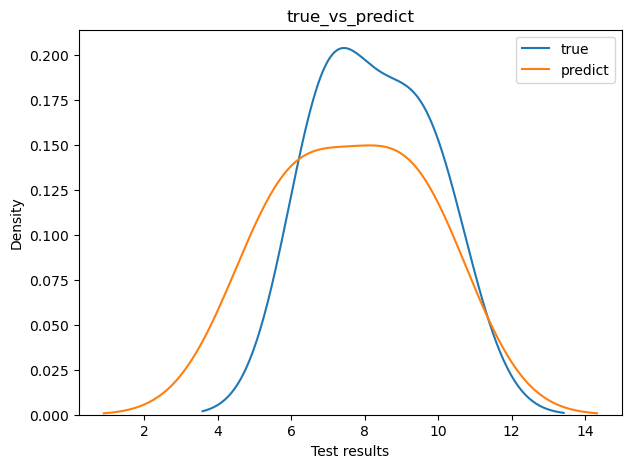

In [60]:
# Построим график сопоставлнеия реальных и прогнозных значений

plt.figure(figsize=(7, 5))
sns.kdeplot(data=list(target_test), label='true')
sns.kdeplot(data=list(predict), label='predict')
plt.xlabel("Test results")
plt.title('true_vs_predict')
plt.legend()
plt.show()

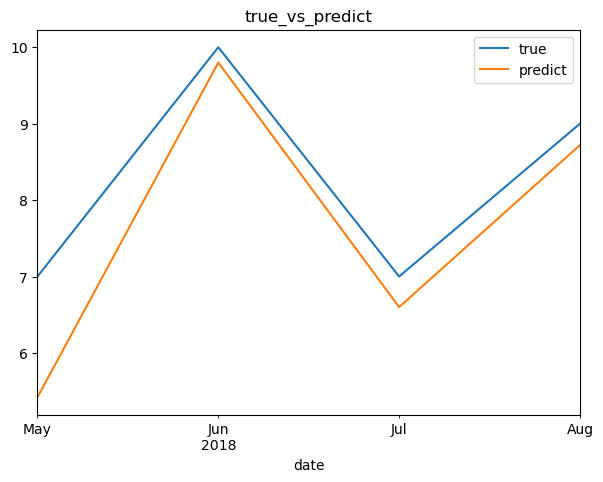

In [61]:
# Построим график временноо ряда

predict_1 = pd.Series(predict)
predict_1.index = target_test.index

plt.figure(figsize=(7, 5))
target_test.plot(label='true', legend=True)
predict_1.plot(label='predict', legend=True)
plt.title('true_vs_predict')
plt.show()

**Выводы**

Предложенная модель `Случайного леса` для прогнозирования продаж на следующий месяц, обеспечивает лучшую точность по метрики `buying_score` **0.9266**

При этом выдерживается условие приоритета значения метрики `buying_score` на уровне **меньшем единицы**

Для достижения этого показателя необходимо сформировать данные с учетом **3** сдвигов и размером окна **5** для параметра скользящее среднее. Параметры `Случайного леса` - число деревьев **10** и глубине дерева **7**
